In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
rcParams['xtick.major.pad']='0'
rcParams['ytick.major.pad']='1'

dpi = 150


c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]
pretty_palette = ["#cb4f70",
          "#1b718c",
          "#779e1a",
          "#f49044"]

In [11]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

dfs = [merf_df, cite_df, larry_df]

for df in dfs:
    df.replace("RandomProjection", "Rand. proj.", inplace=True)
    df.replace("nanoTxformer", "Txformer", inplace=True)

hue_order = ["VAE", "PCA", "Txformer", "Rand. proj."]

In [12]:
def add_delta_mi(df, mi_column):
    avg_random_proj = (
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .transform("mean")
    )
    df["avg_random_proj"] = df["UMI per cell"].map(
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .mean()
    )
    df[f"delta {mi_column}"] = df[mi_column] - df['avg_random_proj']
    df[f"Info gain ({mi_column})"] = df[f"delta {mi_column}"] / np.log10(df['Cell number'])
    return df

cite_df = add_delta_mi(cite_df, "Protein MI")
cite_df = add_delta_mi(cite_df, "Cell type fine MI")
merf_df = add_delta_mi(merf_df, "Spatial neighborhood MI")
larry_df = add_delta_mi(larry_df, "Clonal MI")

In [13]:
def cell_number_scaling(x, A, B, C):
    return C - (A/x)**B

def info_scaling(x, A, B, C):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

VAE Spatial MI
2.845531615957864 0.17708616250841447
0.18868412971628856 0.03642020620200683
693.723537859895 705.4444871629173

PCA Spatial MI
1.8882492430335849 0.017497303121258388
1.200701851144345 0.1934624652621724
35.04015982204378 2.920270719726774

VAE Clonal MI
1.7715363218306346 0.07864070510900205
0.41663211574281006 0.32874461802345006
10.507885595865543 22.116385243320657

PCA Clonal MI
4.131195548512305 None
0.010736681335275363 None
1.8421720451353258e+43 None

VAE Protein MI
4.659773419933058 0.059619543872917444
0.34318200087785 0.06780237745187195
54.915730415994325 8.980564520382206

PCA Protein MI
4.417805668173207 0.018784637438857176
1.04568015636756 0.31200566840779465
41.570817310181035 13.912015212459387

VAE Cell type MI
3.957789277107942 0.23787829645434416
0.12650751237334046 0.06522364580411083
6.19781354377078 7.164766721637955

PCA Cell type MI
3.4011279084508703 0.008496163225762531
4.928335305453102 11.318454151206783
71.21994821540706 76.7812333227084

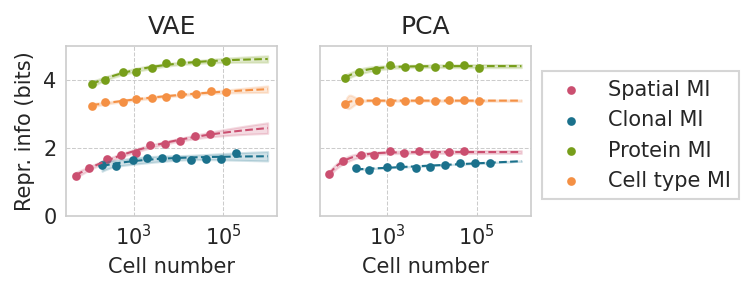

In [36]:
d = {
    "Method" : [],
    "Metric" : [],
    "Quality" : [],
    "A" : [],
    "A std err" : [],
    "B" : [],
    "B std err" : [], 
    "C" : [],
    "C std err" : []
}

dfs = [merf_df, larry_df, cite_df, cite_df]

names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell type MI']
mi_keys = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']


fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), dpi=dpi, sharey=True)

for i, df in enumerate(dfs):
    mi_k = mi_keys[i]
    for method in hue_order:
        for upc in df['UMI per cell'].unique():
            sub_df = df[(df['UMI per cell'] == upc) & (df['Method'] == method)]
            x_data = sub_df['Cell number']
            y_data = sub_df[mi_k]

            model = Model(cell_number_scaling)
            params = model.make_params(A=dict(value=1000, min=0), 
                                B=dict(value=1),
                                C=dict(value=1))
            result = model.fit(y_data, params, x=x_data)

            if method in ['VAE', 'PCA'] and upc == df['UMI per cell'].max():

                ax = axs[hue_order.index(method)]
                ax.scatter(x_data, y_data, label=names[i], color=pretty_palette[i], s=10)

                x_fit = np.logspace(np.log10(np.min(x_data)), 6, 100)
                y_fit = result.eval(x=x_fit)

                ax.plot(x_fit, y_fit, color=pretty_palette[i], lw=1, linestyle='--')

                y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
                y_lower = -y_upper
                ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                                color=pretty_palette[i], alpha=0.2)
                
                ax.set_xscale('log')
                ax.set_ylim(0, 5)
                ax.set_xlabel('Cell number')

                print(method, names[i])
                # print(result.eval(x=np.max(x_data)*10) - result.eval(x=np.max(x_data)))
                # print(result.eval_uncertainty(x=np.max(x_data)*10, params=result.params, sigma=1))
                print(result.params['C'].value, result.params['C'].stderr)
                print(result.params['B'].value, result.params['B'].stderr)
                print(result.params['A'].value, result.params['A'].stderr)
                print()


            # print(result.params['A'].value/0.1**(-result.params['B'].value))

            d['Method'].append(method)
            d['Metric'].append(names[i])
            d['Quality'].append(sub_df['Quality'].unique()[0][1:])
            d['A'].append(result.params['A'].value)
            d['A std err'].append(result.params['A'].stderr)
            d['B'].append(result.params['B'].value)
            d['B std err'].append(result.params['B'].stderr)
            d['C'].append(result.params['C'].value)
            d['C std err'].append(result.params['C'].stderr)

axs[0].set_ylabel('Repr. info (bits)')
axs[0].set_title('VAE')
axs[1].set_title('PCA')
plt.legend(loc=(1.05, 0.1))

/tmp/ipykernel_641806/406614874.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # adjust layout to avoid overlap


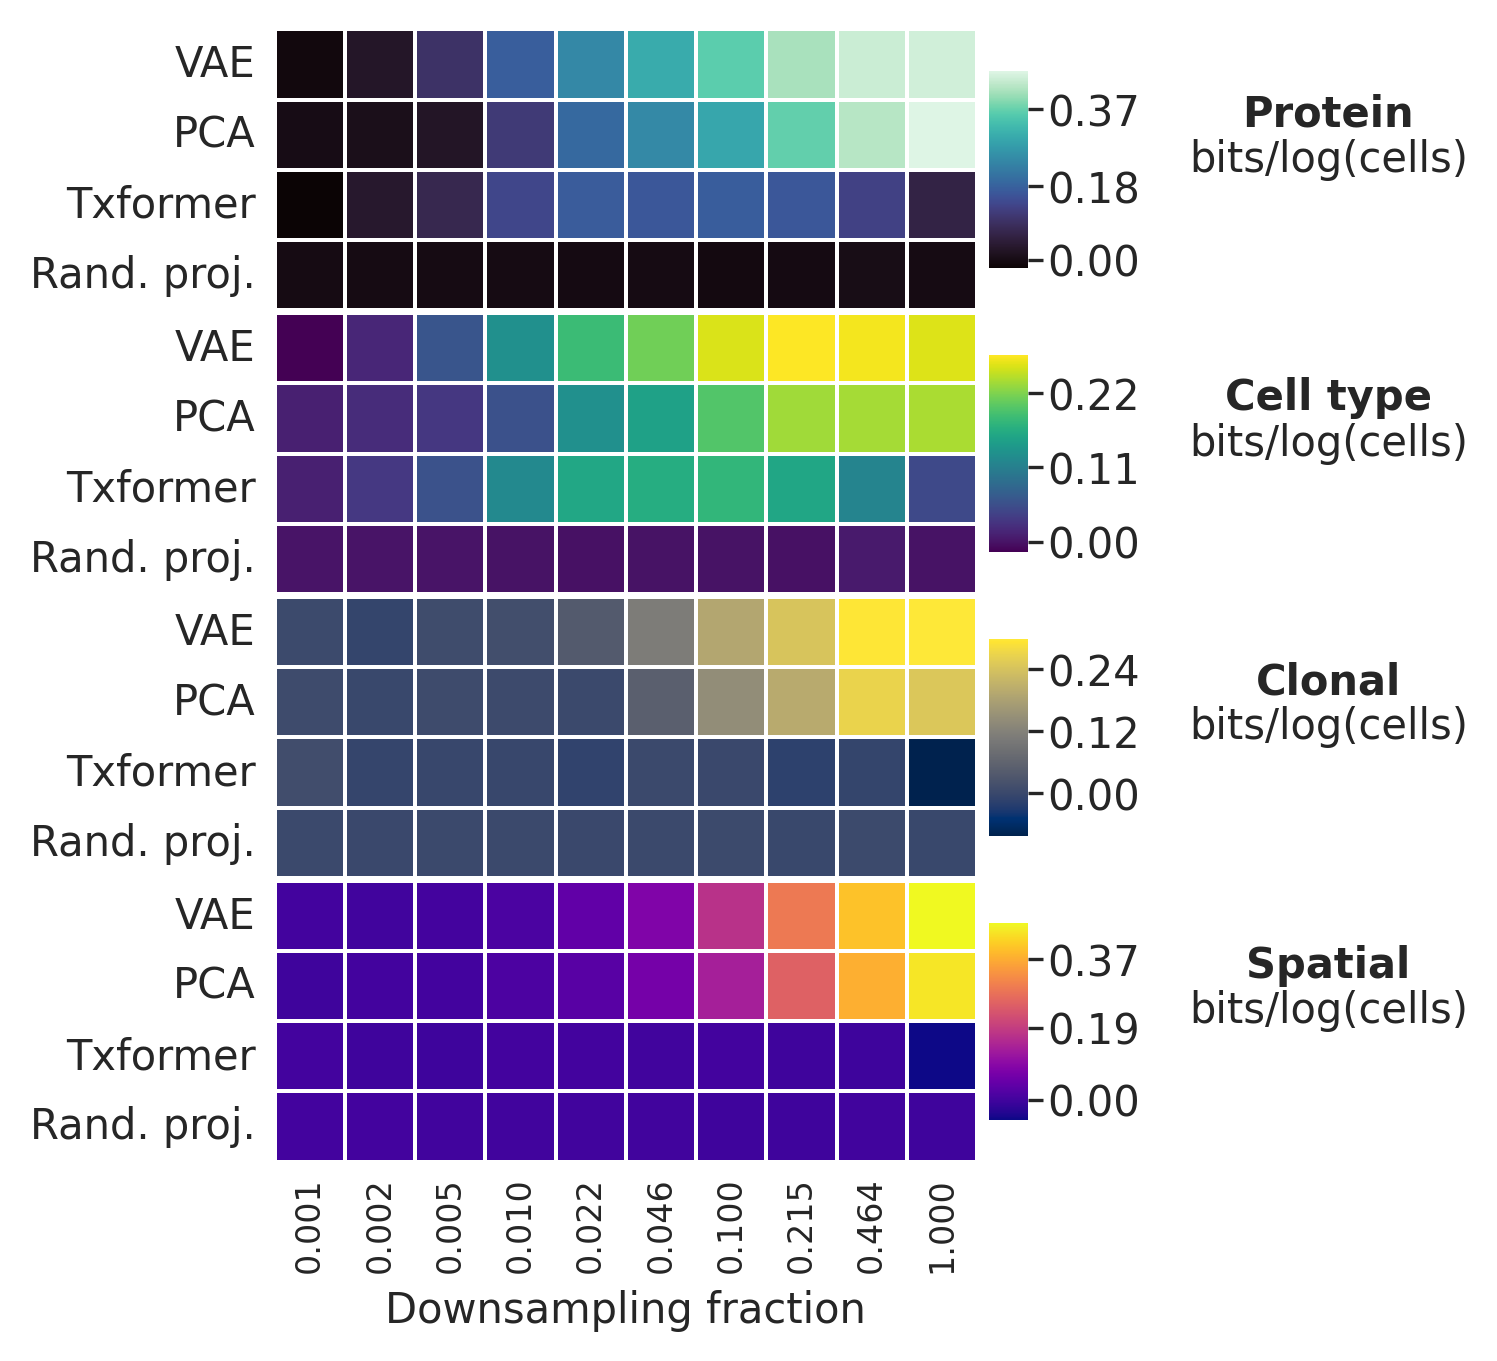

In [7]:
# prepare the data for each heatmap

palettes = ['mako', 'viridis', 'cividis', 'plasma']
heatmaps_data = [
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Protein MI)', aggfunc='mean'),
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Cell type fine MI)', aggfunc='mean'),
    larry_df.pivot_table(columns='Quality', index='Method', 
                         values='Info gain (Clonal MI)', aggfunc='mean'),
    merf_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Spatial neighborhood MI)', aggfunc='mean'),
]

order = ['Protein', 'Cell type', 'Clonal', 'Spatial']

# set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5,5), 
                         gridspec_kw={'hspace': 0.01}, dpi=300)  # control spacing between rows

# plot each heatmap with its own colorbar
for palette, data, ax in zip(palettes, heatmaps_data, axes):
    heatmap = sns.heatmap(data.reindex(['VAE', 'PCA', 'Txformer', 'Rand. proj.']), 
                          ax=ax, square=True, cmap=palette, cbar=True, 
                cbar_kws={'shrink': 0.7, 'aspect': 5, 'pad':0.01,
                          'ticks': [np.round(x, 2) for x in np.linspace(0, data.max().max()*0.8, 3)]},
                        #   'label' : 'Spatial \n info gain'},
                lw=0.5)
    ax.set_xlabel('')  # hide x-axis labels for now
    ax.set_ylabel('')  # optional: remove y-axis labels for compactness
    # ax.set_title('hi')
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    if ax is not axes[-1]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([x.get_text()[1:] for x in ax.get_xticklabels()], fontsize=8)

# only add shared x-axis label to the bottom heatmap
axes[-1].set_xlabel('Downsampling fraction')


for i, name in enumerate(order):
    axes[i].text(15, 1.5, name, va='bottom', ha='center', rotation='horizontal', fontsize=10, weight='bold')
    axes[i].text(15, 1.5, '\nbits/log(cells)', va='center', ha='center', rotation='horizontal', fontsize=10)


plt.tight_layout()  # adjust layout to avoid overlap
plt.show()


In [8]:
fcs = []

q1 = 'Q1.000'
q2 = 'Q0.100'

for i, data in enumerate(heatmaps_data):
    
    
    fcs.append(data.loc['VAE'][q1]/data.loc['VAE'][q2])
    fcs.append(data.loc['PCA'][q1]/data.loc['PCA'][q2])

print(np.mean(fcs))
print(np.min(fcs))
print(order[fcs.index(np.min(fcs))//2])
print()
print(np.max(fcs))
print(order[fcs.index(np.max(fcs))//2])

1.7928872264713782
1.0038679189023982
Cell type

3.2598475513504646
Spatial
